## Load libraries

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
# plt.rcParams['figure.figsize'] = (25, 6)
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 6) 

## Process datasets

### Merge the dataset 20171129
1. Merge the dataset to point_spread.csv and matches.csv
2. Unify the team name
  * JAX -> JAC (NFL use JAX, but just for unification)
  * Buffalo -> BUF
  * LAC -> SD
  * LA -> STL

### Read feature datasets 
from 2009 to 2017

In [48]:
play_cols = ['GameID','Drive','qtr','down','yrdline100','posteam','DefensiveTeam','TimeSecs','sp','ScoreDiff',
            'HomeTeam','AwayTeam']

In [49]:
spread_cols = ['eid','season','week','Home','Away','HomeScore','AwayScore','Day','Time','Favorite','Underdog','Spread','CoverOrNot']

In [50]:
data_files = glob.glob('data/new_data/pbp_20*.csv') # from 2009 to 2017

pbp_data = pd.DataFrame()
for f in data_files:
    d = pd.read_csv(f, usecols=play_cols)
    pbp_data = pd.concat([pbp_data, d])
pbp_data.shape

(388476, 12)

### Merge point spread data

In [51]:
spread_data = pd.read_csv('data/point_spread.csv')

In [52]:
data = pd.merge(pbp_data, spread_data, on='GameID', how='left')

### Deal with missing data

In [53]:
data = data.dropna(axis=0, how='any')

In [54]:
data.shape

(319576, 24)

In [55]:
data = data[data['TimeSecs'] >= 0]

#### Columns to include in the formation of buckets [Down, TimeSecs, YdsToGo and Score Diff]

In [56]:
data['FavScoreDiff'] = data[['posteam','ScoreDiff','Favorite']].apply(
    lambda x: x['ScoreDiff'] if x['posteam']==x['Favorite'] else (-x['ScoreDiff']),axis=1)

In [57]:
data['favTeamOnBall'] = data[['Favorite','posteam']].apply(lambda x: 1 if x['Favorite']==x['posteam'] else -1, axis=1)

## Creating the buckets

In [58]:
data.columns

Index(['GameID', 'Drive', 'qtr', 'down', 'TimeSecs', 'yrdline100', 'posteam',
       'DefensiveTeam', 'sp', 'ScoreDiff', 'HomeTeam', 'AwayTeam', 'season',
       'week', 'Home', 'Away', 'HomeScore', 'AwayScore', 'Day', 'Time',
       'Favorite', 'Underdog', 'Spread', 'CoverOrNot', 'FavScoreDiff',
       'favTeamOnBall'],
      dtype='object')

In [16]:
data['DownClass'] = pd.cut(data['down'], bins=[0.5,1.5,2.5,3.5,4.5], labels=[1,2,3,4])

In [46]:
bins = list(range(0, 3601, 60))
bins.append(np.inf)
data['TimeSecsClass'] = pd.cut(data['TimeSecs'], bins=bins, labels=range(1,62), include_lowest=True)

In [24]:
bins = list(range(0,101,10))
data['yrdline100Class'] = pd.cut(data['yrdline100'],bins=bins, labels=list(range(1,11)))

In [25]:
bins = [-np.inf, -35, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 35, np.inf] #15 items
data['FavScoreDiffClass'] = pd.cut(data['FavScoreDiff'],bins=bins, labels=list(range(1,15)))

In [26]:
data.head(10)

,GameID,Drive,qtr,down,TimeSecs,yrdline100,posteam,DefensiveTeam,sp,ScoreDiff,...,Favorite,Underdog,Spread,CoverOrNot,FavScoreDiff,favTeamOnBall,DownClass,TimeSecsClass,yrdline100Class,FavScoreDiffClass
1,2013090500,1,1,1.0,3600.0,80.0,BAL,DEN,0,0.0,...,DEN,BAL,-7.5,1.0,-0.0,-1,1,59,8,7
2,2013090500,1,1,2.0,3554.0,81.0,BAL,DEN,0,0.0,...,DEN,BAL,-7.5,1.0,-0.0,-1,2,59,9,7
3,2013090500,1,1,3.0,3518.0,78.0,BAL,DEN,0,0.0,...,DEN,BAL,-7.5,1.0,-0.0,-1,3,58,8,7
4,2013090500,1,1,4.0,3498.0,72.0,BAL,DEN,0,0.0,...,DEN,BAL,-7.5,1.0,-0.0,-1,4,58,8,7
5,2013090500,2,1,1.0,3490.0,77.0,DEN,BAL,0,0.0,...,DEN,BAL,-7.5,1.0,0.0,1,1,58,8,7
6,2013090500,2,1,2.0,3485.0,77.0,DEN,BAL,0,0.0,...,DEN,BAL,-7.5,1.0,0.0,1,2,58,8,7
7,2013090500,2,1,3.0,3445.0,76.0,DEN,BAL,0,0.0,...,DEN,BAL,-7.5,1.0,0.0,1,3,57,8,7
8,2013090500,2,1,1.0,3424.0,66.0,DEN,BAL,0,0.0,...,DEN,BAL,-7.5,1.0,0.0,1,1,57,7,7
9,2013090500,2,1,2.0,3418.0,66.0,DEN,BAL,0,0.0,...,DEN,BAL,-7.5,1.0,0.0,1,2,56,7,7
10,2013090500,2,1,3.0,3384.0,59.0,DEN,BAL,0,0.0,...,DEN,BAL,-7.5,1.0,0.0,1,3,56,6,7


In [27]:
class_names = ['FavScoreDiffClass','yrdline100Class','TimeSecsClass','DownClass']

Now temp contains the count of each existing class. From here, we've to add 0 for values of the classes that don't exist. The following code does that.

In [28]:
# Count the total plays in each bucket irrespective of bet_cleared or not
countNoZero = data.groupby(class_names).size().reset_index(name='counts')
# Counting the values in each bucket
bucket_full = pd.pivot_table(countNoZero,
                           index=class_names,
                           values='counts',
                           fill_value = 0,
                           dropna=False,
                           aggfunc=np.sum)

new_table stores the count for each class.

In [29]:
bucket_full['counts'] = bucket_full['counts']+2

In [30]:
full_buc_count = list(bucket_full['counts'])

Now we will work to get the count for each bucket with only the matches for which the bet was cleared

In [31]:
class_names = ['CoverOrNot','FavScoreDiffClass','yrdline100Class','TimeSecsClass','DownClass']

In [32]:
countNoZeroCover = data.groupby(class_names).size().reset_index(name='counts')

In [33]:
# Counting the plays in each bucket for which the bet was cleared
bucket_half = pd.pivot_table(countNoZeroCover,
                           index=class_names,
                           values='counts',
                           fill_value = 0,
                           dropna=False,
                           aggfunc=np.sum)

In [34]:
bucket_half['counts'] = bucket_half['counts']+1

In [35]:
half_buc_count = list(bucket_half['counts'].loc[bucket_half.index.get_level_values('CoverOrNot')==1])

In [36]:
# Final Probability vector for each bucket
prob_buc = [float(half_buc_count[i])/float(full_buc_count[i]) for i in range(len(full_buc_count))]

**prob_buc** stores the probability of bet clearing probability of each bucket

In [37]:
bucket_full['counts'] = prob_buc

In [38]:
bucket_full.head()

counts
FavScoreDiffClass yrdline100Class TimeSecsClass DownClass          
1                 1               0             1          0.500000
                                                2          0.500000
                                                3          0.333333
                                                4          0.500000
                                  1             1          0.333333

#### As clear from the above structure, bucket_full now contains the probability of each bucket.
We will now use these probabilities to assign each play a probability based on which bucket that play lies in

## Assigning each play a probability wrt it's bucket

In [39]:
bucket_full = bucket_full.reset_index()

In [42]:
data.head()

,GameID,Drive,qtr,down,TimeSecs,yrdline100,posteam,DefensiveTeam,sp,ScoreDiff,...,Underdog,Spread,CoverOrNot,FavScoreDiff,favTeamOnBall,DownClass,TimeSecsClass,yrdline100Class,FavScoreDiffClass,counts
0,2013090500,1,1,1.0,3600.0,80.0,BAL,DEN,0,0.0,...,BAL,-7.5,1.0,-0.0,-1,1,59,8,7,0.464577
1,2013090500,1,1,2.0,3554.0,81.0,BAL,DEN,0,0.0,...,BAL,-7.5,1.0,-0.0,-1,2,59,9,7,0.467181
2,2013090500,1,1,3.0,3518.0,78.0,BAL,DEN,0,0.0,...,BAL,-7.5,1.0,-0.0,-1,3,58,8,7,0.509346
3,2013090500,1,1,4.0,3498.0,72.0,BAL,DEN,0,0.0,...,BAL,-7.5,1.0,-0.0,-1,4,58,8,7,0.464730
4,2013090500,2,1,1.0,3490.0,77.0,DEN,BAL,0,0.0,...,BAL,-7.5,1.0,0.0,1,1,58,8,7,0.473934


In [41]:
data = pd.merge(data, bucket_full, on=['FavScoreDiffClass','yrdline100Class','TimeSecsClass','DownClass'], how='left')

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


In [43]:
data = data.rename(columns={"counts":"Prob"})

In [44]:
hola = data.set_index('GameID')

In [45]:
hola.to_csv('data/full_data')

### Plots

#### Fixing score difference, graph of time left vs Prob

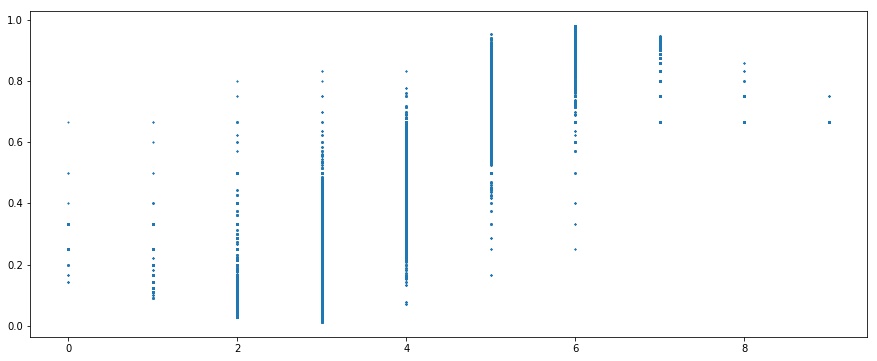

In [33]:
plt.scatter(data['FavScoreDiffClass'],data['Prob'], s=0.5)
plt.show()

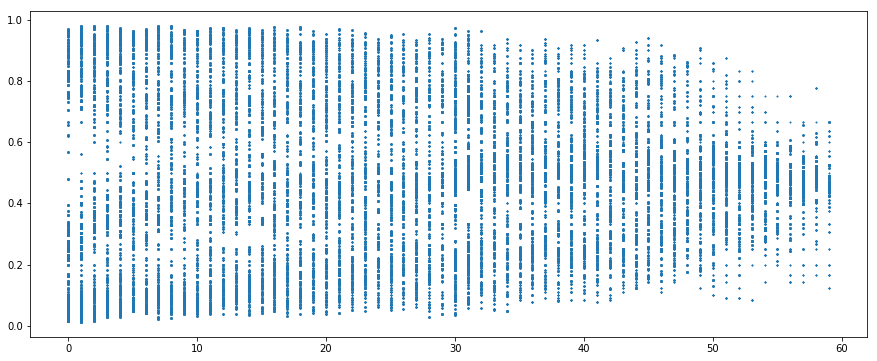

In [34]:
plt.scatter(data['TimeSecsClass'], data['Prob'], s=0.5)
plt.show()

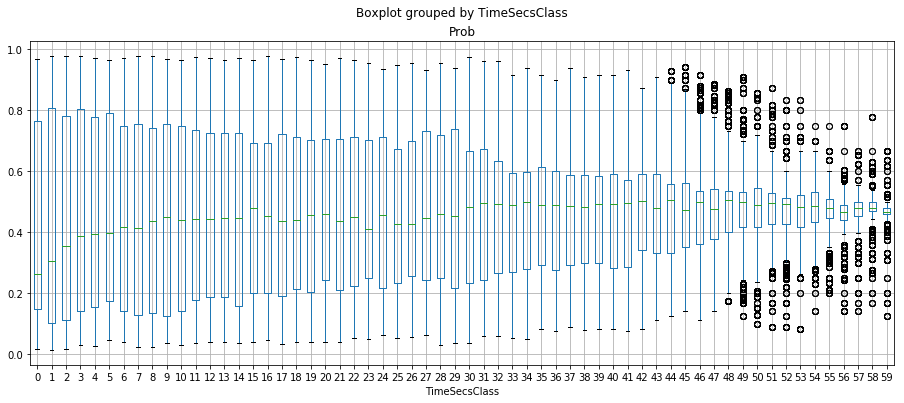

In [36]:
data[['TimeSecsClass','Prob']].boxplot(column='Prob', by='TimeSecsClass')
plt.show()
# small_data[['Prob','yrdline100']].boxplot(column='Prob',by='yrdline100')

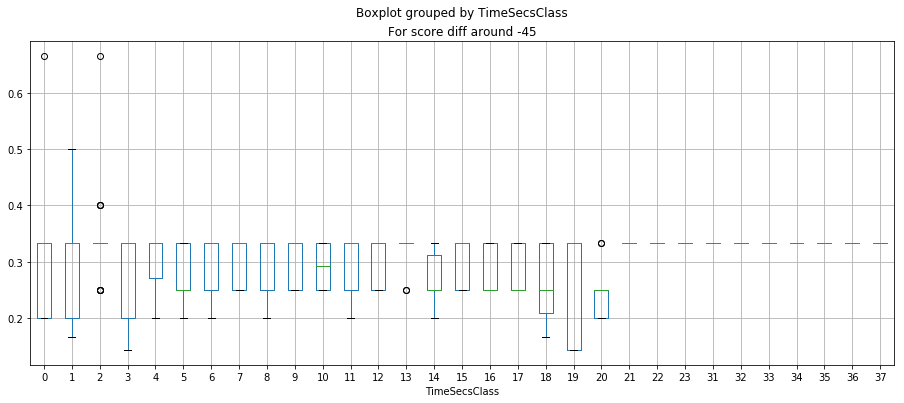

In [57]:
small_data = data[data['FavScoreDiffClass']==0]
small_data[['TimeSecsClass','Prob']].boxplot(column='Prob',by='TimeSecsClass')
plt.title('For score diff around -45')
plt.show()


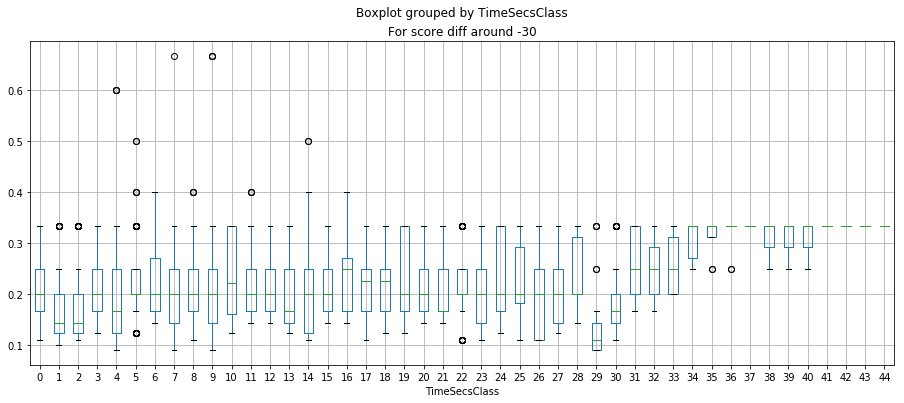

In [56]:
small_data = data[data['FavScoreDiffClass']==1]
small_data[['TimeSecsClass','Prob']].boxplot(column='Prob',by='TimeSecsClass')
plt.title('For score diff around -30')
plt.show()

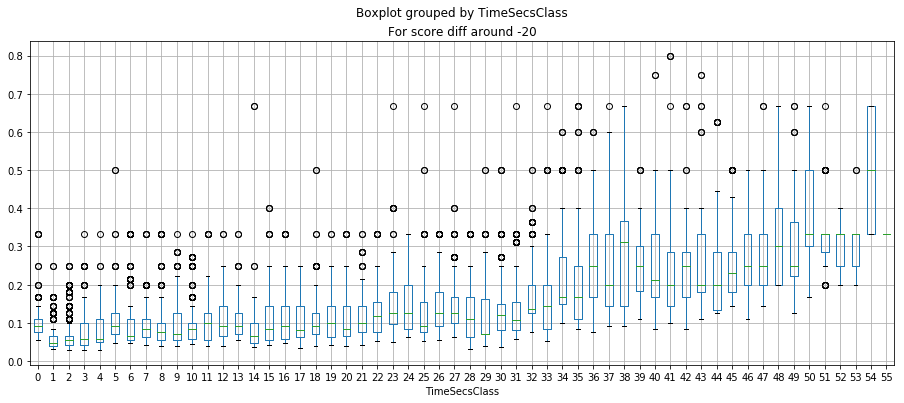

In [55]:
small_data = data[data['FavScoreDiffClass']==2]
small_data[['TimeSecsClass','Prob']].boxplot(column='Prob',by='TimeSecsClass')
plt.title('For score diff around -20')
plt.show()

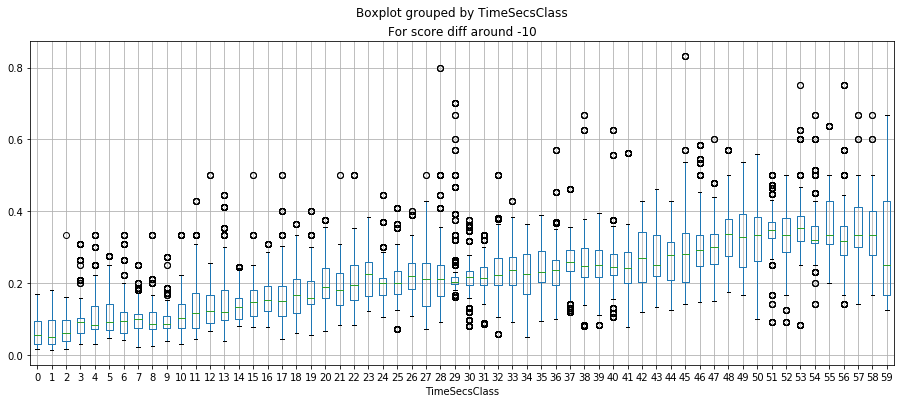

In [54]:
small_data = data[data['FavScoreDiffClass']==3]
small_data[['TimeSecsClass','Prob']].boxplot(column='Prob',by='TimeSecsClass')
plt.title('For score diff around -10')
plt.show()

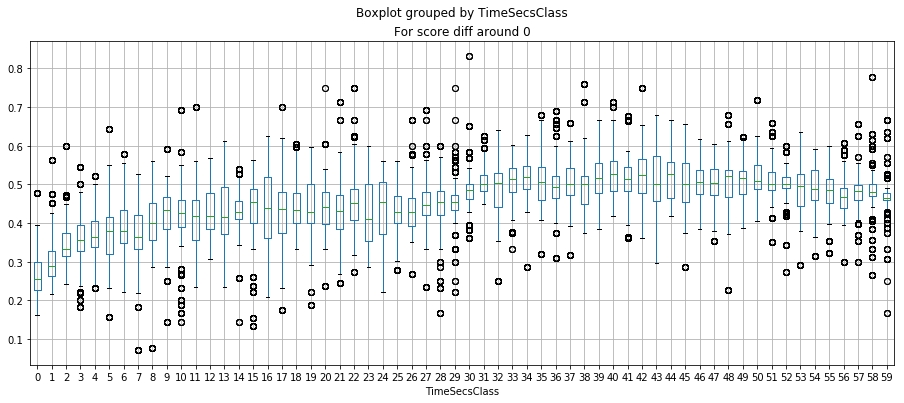

In [53]:
small_data = data[data['FavScoreDiffClass']==4]
small_data[['TimeSecsClass','Prob']].boxplot(column='Prob',by='TimeSecsClass')
plt.title('For score diff around 0')
plt.show()

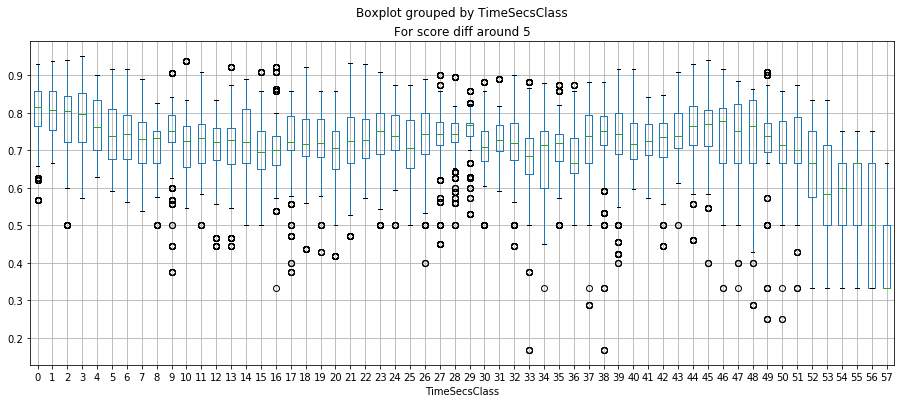

In [52]:
small_data = data[data['FavScoreDiffClass']==5]
small_data[['TimeSecsClass','Prob']].boxplot(column='Prob',by='TimeSecsClass')
plt.title('For score diff around 5')
plt.show()

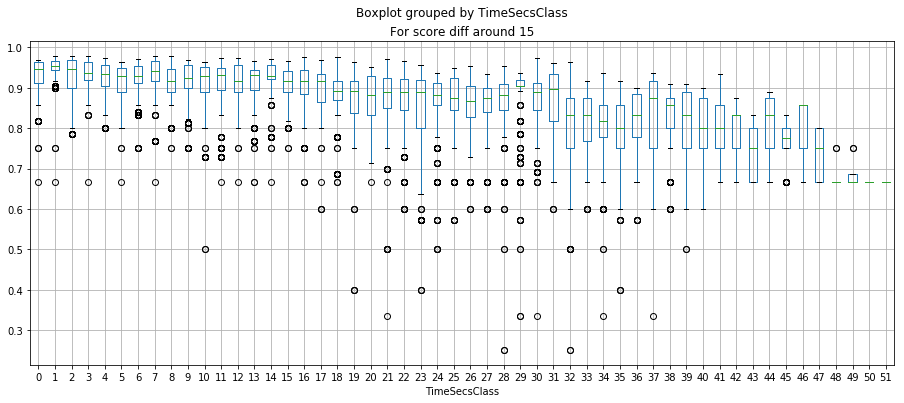

In [51]:
small_data = data[data['FavScoreDiffClass']==6]
small_data[['TimeSecsClass','Prob']].boxplot(column='Prob',by='TimeSecsClass')
plt.title('For score diff around 15')
plt.show()

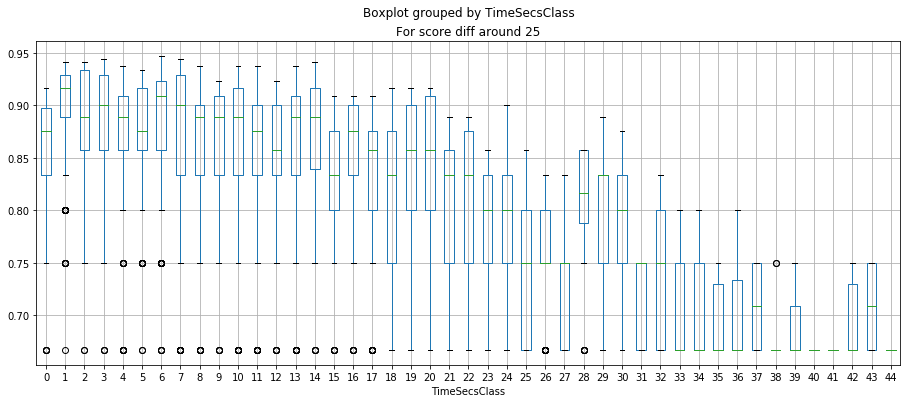

In [49]:
small_data = data[data['FavScoreDiffClass']==7]
small_data[['TimeSecsClass','Prob']].boxplot(column='Prob',by='TimeSecsClass')
plt.title('For score diff around 25')
plt.show()

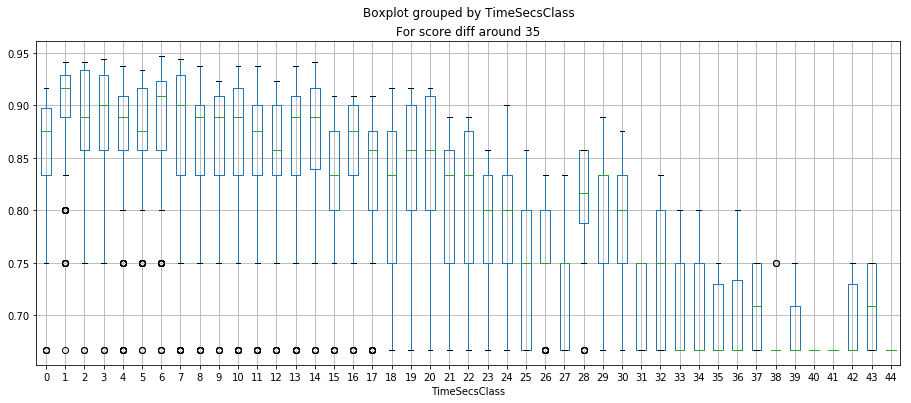

In [58]:
small_data = data[data['FavScoreDiffClass']==7]
small_data[['TimeSecsClass','Prob']].boxplot(column='Prob',by='TimeSecsClass')
plt.title('For score diff around 35')
plt.show()

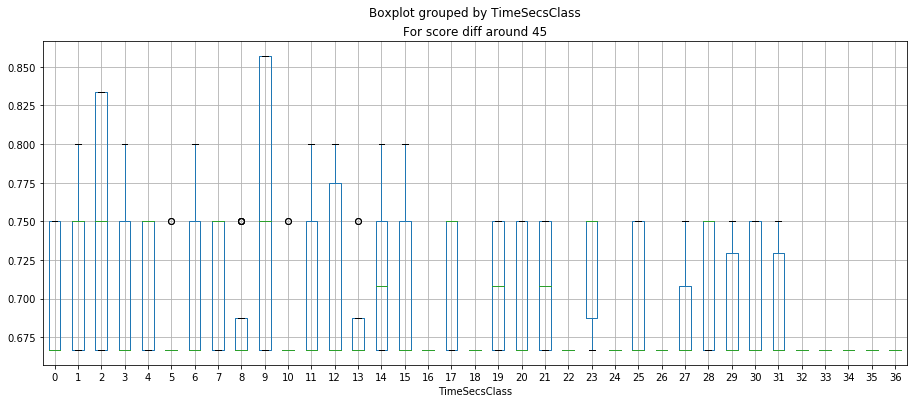

In [59]:
small_data = data[data['FavScoreDiffClass']==8]
small_data[['TimeSecsClass','Prob']].boxplot(column='Prob',by='TimeSecsClass')
plt.title('For score diff around 45')
plt.show()

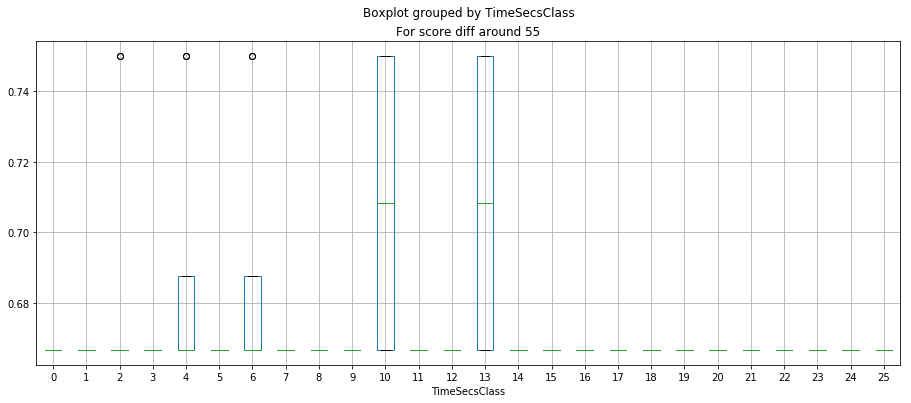

In [60]:
small_data = data[data['FavScoreDiffClass']==9]
small_data[['TimeSecsClass','Prob']].boxplot(column='Prob',by='TimeSecsClass')
plt.title('For score diff around 55')
plt.show()

In [73]:
data.head()

,GameID,Drive,qtr,down,TimeSecs,yrdline100,posteam,DefensiveTeam,sp,ScoreDiff,...,Underdog,Spread,CoverOrNot,FavScoreDiff,favTeamOnBall,DownClass,TimeSecsClass,yrdline100Class,FavScoreDiffClass,Prob
0,2013090500,1,1,1.0,3600.0,80.0,BAL,DEN,0,0.0,...,BAL,-7.5,1.0,-0.0,-1,0,59,8,4,0.465719
1,2013090500,1,1,2.0,3554.0,81.0,BAL,DEN,0,0.0,...,BAL,-7.5,1.0,-0.0,-1,1,59,8,4,0.442890
2,2013090500,1,1,3.0,3518.0,78.0,BAL,DEN,0,0.0,...,BAL,-7.5,1.0,-0.0,-1,2,58,7,4,0.520737
3,2013090500,1,1,4.0,3498.0,72.0,BAL,DEN,0,0.0,...,BAL,-7.5,1.0,-0.0,-1,3,58,7,4,0.459350
4,2013090500,2,1,1.0,3490.0,77.0,DEN,BAL,0,0.0,...,BAL,-7.5,1.0,0.0,1,0,58,7,4,0.479508


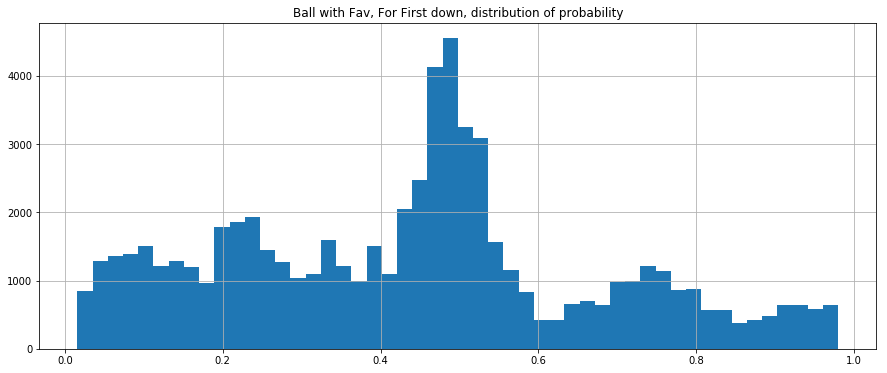

In [87]:
small_data = data[(data['favTeamOnBall']==1) & (data['DownClass']==0)]
small_data['Prob'].hist(bins=50)
plt.title('Ball with Fav, For First down, distribution of probability')
plt.show()

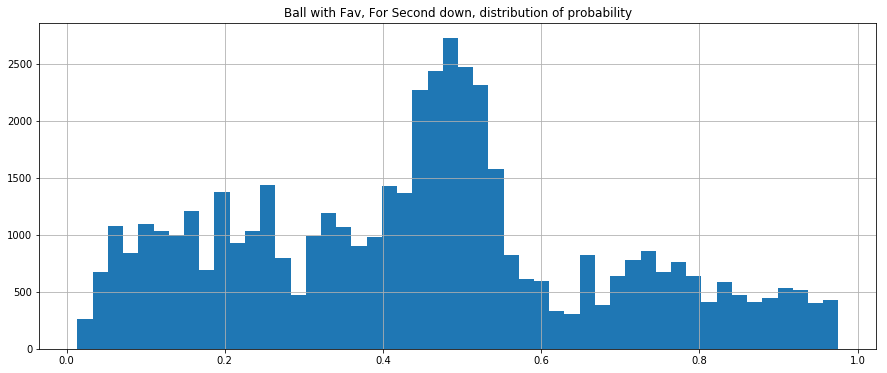

In [88]:
small_data = data[(data['favTeamOnBall']==1) & (data['DownClass']==1)]
small_data['Prob'].hist(bins=50)
plt.title('Ball with Fav, For Second down, distribution of probability')
plt.show()

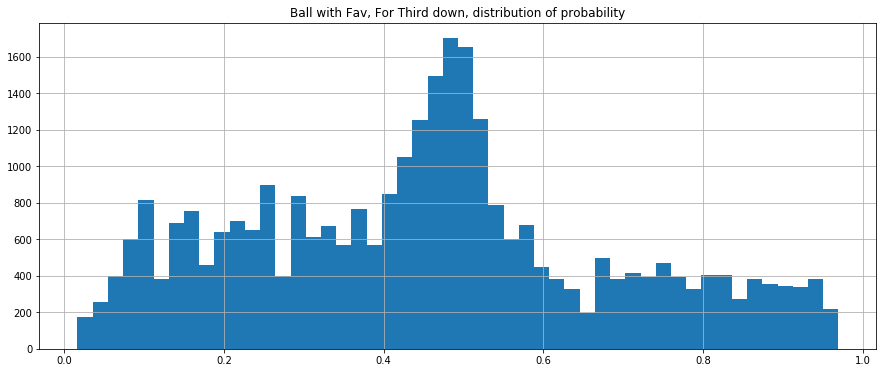

In [89]:
small_data = data[(data['favTeamOnBall']==1) & (data['DownClass']==2)]
small_data['Prob'].hist(bins=50)
plt.title('Ball with Fav, For Third down, distribution of probability')
plt.show()

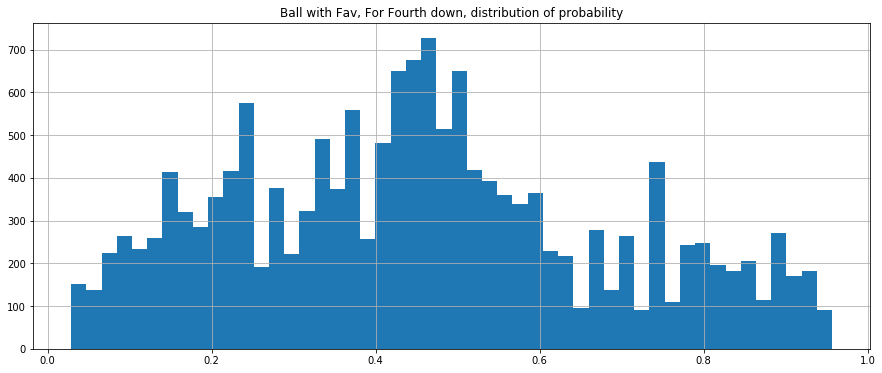

In [90]:
small_data = data[(data['favTeamOnBall']==1) & (data['DownClass']==3)]
small_data['Prob'].hist(bins=50)
plt.title('Ball with Fav, For Fourth down, distribution of probability')
plt.show()

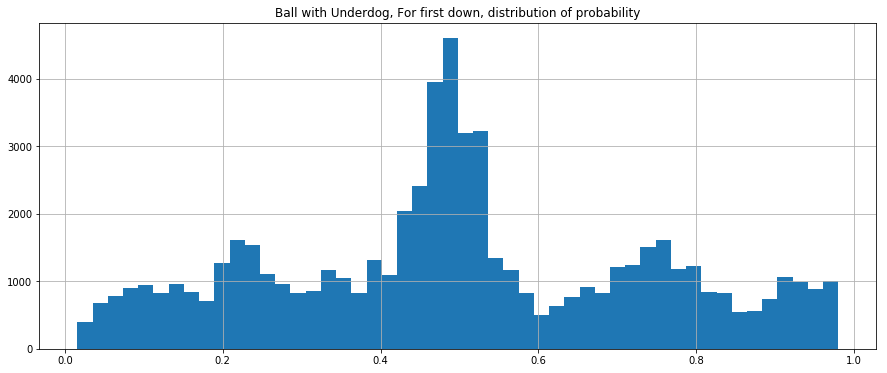

In [91]:
small_data = data[(data['favTeamOnBall']==-1) & (data['DownClass']==0)]
small_data['Prob'].hist(bins=50)
plt.title('Ball with Underdog, For first down, distribution of probability')
plt.show()

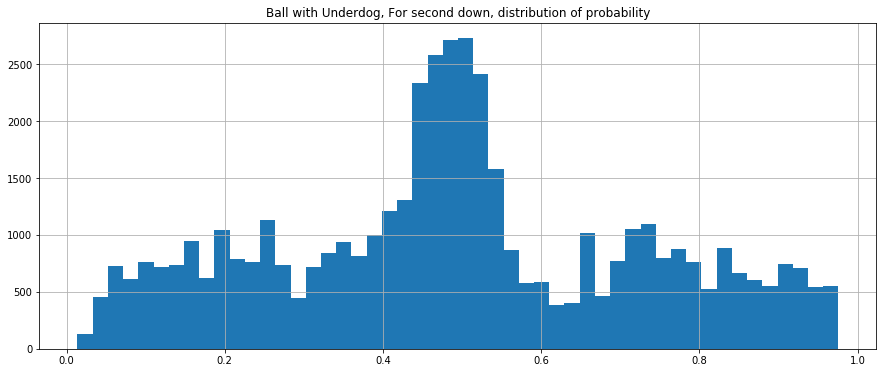

In [92]:
small_data = data[(data['favTeamOnBall']==-1) & (data['DownClass']==1)]
small_data['Prob'].hist(bins=50)
plt.title('Ball with Underdog, For second down, distribution of probability')
plt.show()

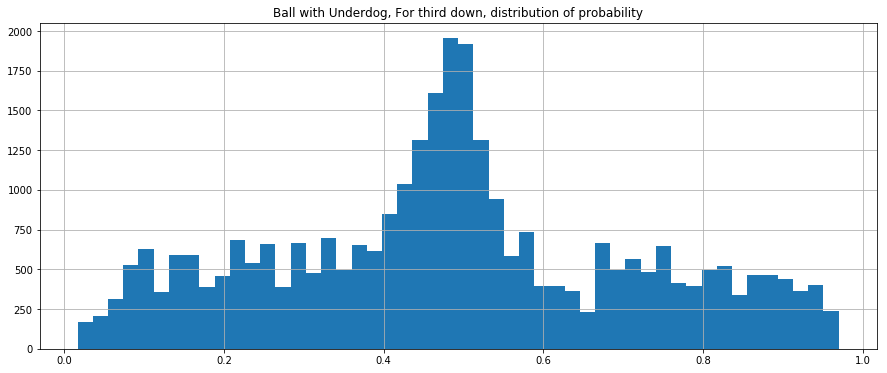

In [93]:
small_data = data[(data['favTeamOnBall']==-1) & (data['DownClass']==2)]
small_data['Prob'].hist(bins=50)
plt.title('Ball with Underdog, For third down, distribution of probability')
plt.show()

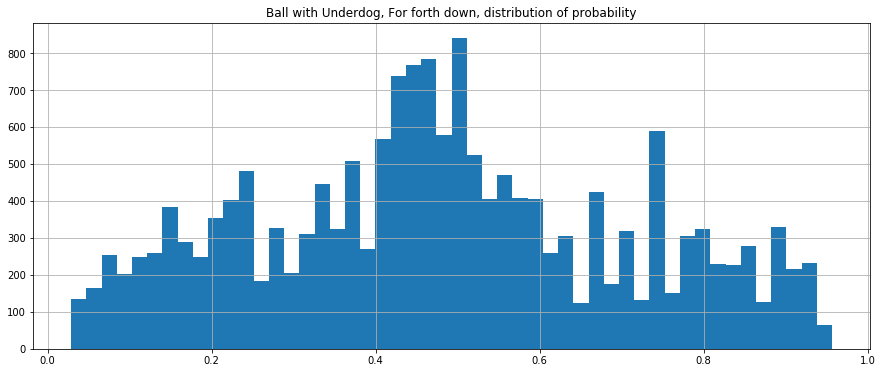

In [94]:
small_data = data[(data['favTeamOnBall']==-1) & (data['DownClass']==3)]
small_data['Prob'].hist(bins=50)
plt.title('Ball with Underdog, For forth down, distribution of probability')
plt.show()

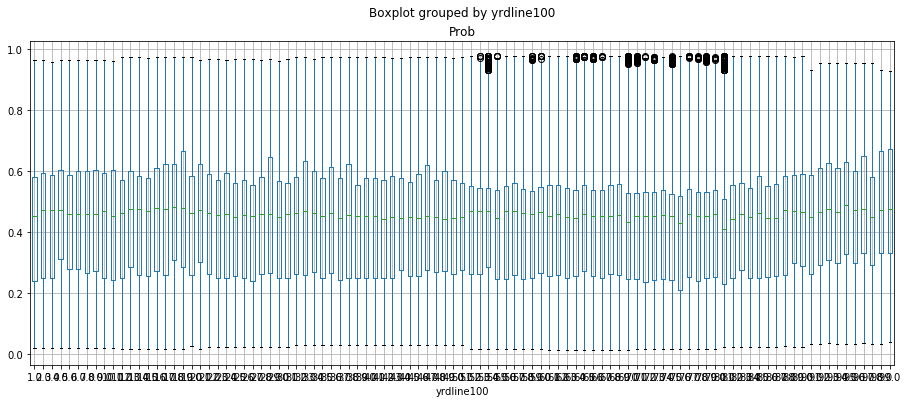

In [100]:
small_data = data[data['favTeamOnBall']==1]
small_data[['Prob','yrdline100']].boxplot(column='Prob',by='yrdline100')
plt.show()

In [62]:
data.to_csv('data/full_data.csv')